<img src='img/banner.png' align='right' width='100%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For a smooth experience, some actions are needed:
    
* It is expected for the user to be familiar with Python.
* The LSA SAF METREF product for the dates January 1,  2020, to December 31,  2023, in `NetCDF4` format needs to be downloaded from the [LSA SAF Data Server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/METREF/).
    
</div>

<hr>

## Comparing LSA SAF METREF Data with Evapotranspiration Estimates Based on In-situ Measurements

#### About

Evapotranspiration (ET) is a measure of the amount of water, that evaporates from the soil and transpires from vegetation. In this notebook, we will compare in-situ estimates of reference evapotranspiration (ET0) calculated using Penman-Monteith formula with LSA SAF Reference Evapotranspiration [LSA SAF METREF](https://landsaf.ipma.pt/en/data/products/evapotranspiration-turbulent-fluxes/) data. The LSA SAF METREF product is a type of ET0 estimation, that assumes, that the soil is covered with 12 cm tall, well-watered grass with an albedo of 0.23.

Penmann-Monteith algorithm for calculation of reference evapotranspiration (ET_PM), particularly the [FAO Penman-Monteith formula](https://www.fao.org/3/X0490E/x0490e00.htm) ET_PM is a de facto standard in agriculture and meteorology. It is based on in-situ measurements of meteorological variables, such as temperature, humidity, radiation, wind speed, etc. [reference](https://www.fao.org/3/X0490E/x0490e06.htm#fao%20penman%20monteith%20equation).

The LSA SAF METREF algorithm [Algorithm Theoretical Basis Document](https://nextcloud.lsasvcs.ipma.pt/s/zzBDmfgtJE9ePQW?dir=undefined&path=%2FATBD&openfile=27248) provides ET0 estimation based on observations from the Meteosat Second Generation (MSG) satellite in combination with inputs from the European Centre for Medium-Range Weather Forecasts's (ECMWF) numerical weather prediction model. It provides ET0 estimation on MSG-disk on a daily basis.

We analyze in-situ ET_PM estimations provided by the Slovenian Meteorological Agency (ARSO) at the locations of Maribor, Bilje and Novo Mesto in Slovenia. The goal of our analysis is to compare LSA SAF METREF data (satellite-based) with in-situ calculated ET_PM values.

Additionally, we will check if both methods can be used interchangeably. An effort to detect potential systematic effects in their difference will be also made as well as an uncertainty estimation.

For a more detailed validation of LSA SAF METREF, additional information can be accessed at the [validation report](https://nextcloud.lsasvcs.ipma.pt/s/zzBDmfgtJE9ePQW?dir=undefined&path=%2FVR&openfile=27256).

#### How to access the data

* For this example, LSA SAF METREF measurements from January 1,  2020, to December 31,  2023, are used. All measurements are available as NetCDF4 as well as HDF5 files, but only the former will be used here. The LSA SAF  files can be downloaded from the [data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/) available at https://datalsasaf.lsasvcs.ipma.pt/ with prior registration. Data can be downloaded in various ways, for instance manually, using approach published on [lsasaf_data_access GitLab](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/blob/main/examples/webdav/webdav_colab_example.ipynb) repository or using [WebDAV protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/webdav). An additional option is to use the `GNU Wget` program. In this notebook, it is assumed that the required files are already available locally in the folder `Data_ETP` in the same directory as this notebook.

* ET_PM estimates calculated from in-situ measurements are available as an attachment to this notebook in the `ET_PM.csv` file. These ET_PM estimations are publicly available on the [ARSO website](https://meteo.arso.gov.si/met/sl/agromet/data/arhiv_etp/). ET_PM estimations are provided for every location separately. In order to access them manually, the following procedure needs to be used: data for Bilje, Maribor-letališče (airport) and Novo mesto need to be downloaded and extracted from a `zip` file and saved in the same directory as this notebook. The `Data_preparation_METREF_In_Situ_ET_Comparison.py` script, attached to this notebook, needs to be used to merge 3 sets of raw measurements into one file and translate the data header from Slovenian to English language. The raw data includes 2 columns of data; evapotranspiration estimates as well as precipitation estimation. The `Data_preparation_METREF_In_Situ_ET_Comparison.py` code drops the precipitation data and data that is not included in the analyzed time interval (January 1, 2020, to December 31, 2023) and at the end saves ET_PM estimations as the `ET_PM.csv` file.

#### Basic Facts on the LSA SAF METREF product
> **Product number**: LSA-303
>
> **Spatial resolution**: 3 km at andir
> 
> **Spatial coverage**: MSG-Disk
> 
> **Time steps**: 1 day
> 
> **Data availability**: From 2016 (Climate Data Records available in 2004-2015)

> 

#### Module outline:
* [1 - Defining the Utility Functions](#First)
* [2 - Importing of the In-Situ Measurements](#Second)
* [3 - Preparing the LSA SAF METREF Data](#Third)
* [4 - Plotting](#Fourth)
    * [4.1 - Creating Subplots](#Fourth-one)
* [5 - Comparing the Measurements](#Fifth)
* [6 - Distribution of the METREF-$ET_0$ Difference](#Sixth)
* [7 - The Tukey Mean-Difference Plot](#Seventh)
* [8 - The Uncertainty Assessment Mean-Difference Plot](#Eighth)

<hr>

#### Load required libraries

In [1]:
import pandas as pd                 # A library for data manipulation and analysis
import matplotlib.pyplot as plt     # A library for plotting
import numpy as np                  # A library for numerical computing and working with n-dimensional unlabeled arrays
import xarray as xr                 # A library for working with labeled n-dimensional arrays

# Set the matplotlib backend to inline
%matplotlib inline

### <a id='First'></a>1. Defining Utility Functions

We will access the locally stored LSA SAF METREF data in the `NetCDF4` format, which can be opened using the `xarray` library.
To make the process of extracting values from `NetCDF4` files clearer we could define the following functions:

* `get_MSG_product_filename()`, which returns the name of the `NetCDF4` file of a particular product at a particular time,

* `get_data()` which returns the value of the chosen product at a particular time and location.

Both functions are generalized, so that they can be reused to access various ET-related LSA SAF products (METREF, DMETv3 and DMET) and with some modifications also other LSA SAF products.
The path of the folder containing `NetCDF4` files is specified as an argument `file_location` in the `get_MSG_product_filename()` and `get_data()` functions.

In [2]:
def get_MSG_product_filename(date, product, file_location):
    """
    Constructs the filename for a LSA SAF product file from the given parameters.

    Args:
        - date (pd.datetime): The date of the interest. Should be a pandas datetime object.
        - product (str): The name of LSA SAF product  ("DMETv3", "DMET", or "METREF").
        - file_location (str): The location where the product file is stored. Should be a valid file path.

    Returns:
        - str: The constructed filename for the evapotranspiration product file.
    """

    filename = (
        file_location
        + "NETCDF4_LSASAF_MSG_"
        + product
        + "_MSG-Disk_"
        + str("{:02d}".format(date.year))
        + str("{:02d}".format(date.month))
        + str("{:02d}".format(date.day))
        + "0000.nc"
    )

    return filename

The `get_data()` function employs the `xarray` library to load a `NetCDF4` file. It extracts the value from the pixel that is closest to the location of interest using `ds.sel()`method, which is discussed in more details in the [xarray documentation](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html).

It can be used to access the METREF value when the `variable` argument is set to `"METREF"` or its quality flag, when the argument is set to `"quality_flag"`.

In [3]:
def get_data(
    date, product, variable, lat_input, lon_input, file_location, print_error=True
):
    """
    Loads locally saved LSA SAF product NetCDF4 file into a dataset
    and returns value for one point (lat-lon)


    Args:
        - date (pd.datetime): Date of the product. Should be provided as a pandas datetime object.
        - product (str): The type of LSA SAF data. It should be one of "DMETv3", "DMET", or "METREF".
        - variable (str): Variable of interest (NetCDF4 files consist of multiple variables)
          Should be "METREF" for METREF product and "ET" for DMET products.
        - lat_input (float): Latitude.
        - lon_input (float): Longitude.
        - file_location (str): The location where the product file is stored. Should be a valid file path.
        - print_error (bool): Show problems, e.g., a missing NetCDF4 file.

    Returns:
        - float: Product value of interest.
    """

    try:
        LSA_SAF_ds = xr.open_dataset(
            get_MSG_product_filename(date, product, file_location), decode_times=False
        )

        LSA_SAF_value = (
            LSA_SAF_ds.sel(lat=[lat_input], lon=[lon_input], method="nearest")[variable]
            .load()
            .values[0, 0, 0]
        )

        LSA_SAF_ds.close()

        return LSA_SAF_value

    # Handle exceptions
    except Exception as e:
        if print_error:
            print(e)
            print("Missing data for: " + str(date))

        return np.nan

### <a id='Second'></a>2. Import In-Situ Measurements

We import ET_PM data from three Slovenian in-situ sites: Bilje, Maribor and Novo mesto. Each in-situ location is located in a different part of Slovenia and has different land cover characteristics in the vicinity of the location (e.g., fields, vineyards, forests etc.).

Here we need to specify the meteorological station's latitude and longitude so that we are able to extract the corresponding LSA SAF METREF values from `NetCDF4` files later on.

In [4]:
# Dataframe containing locations and descriptions is constructed
locations_df = pd.DataFrame(
    [
        ["Bilje", 45.89583, 13.62889, "Vineyards"],
        ["Maribor", 46.48, 15.68694, "Fields"],
        ["Novo mesto", 45.80194, 15.18222, "Urbanized/Fields"],
    ],
    columns=["name", "lat", "lon", "type"],
)

# Check the dataframe
print(locations_df)

         name       lat       lon              type
0       Bilje  45.89583  13.62889         Vineyards
1     Maribor  46.48000  15.68694            Fields
2  Novo mesto  45.80194  15.18222  Urbanized/Fields


The ET_PM data are available as a `.csv` file and can be further processed using the `pandas` library. The ET_PM estimations are provided by ARSO. The data points are already ordered by both date and location. After importing the data in the dataframe `df` we explicitly convert the date column to the `date time` object. 

The missing values are already deleted, otherwise, this could be done at this stage using the `df.dropna()` function.

In [5]:
# Read the data from csv
df = pd.read_csv("ET_PM.csv")

# Convert dates do pd.datetime format
df["date"] = pd.to_datetime(df["date"])

# Check the resulting dataframe
print(df)


            name       date  ET0
0          Bilje 2020-01-01  0.6
1          Bilje 2020-01-02  0.7
2          Bilje 2020-01-04  0.6
3          Bilje 2020-01-06  0.8
4          Bilje 2020-01-07  0.5
...          ...        ...  ...
4374  Novo mesto 2023-12-27  0.4
4375  Novo mesto 2023-12-28  0.9
4376  Novo mesto 2023-12-29  0.9
4377  Novo mesto 2023-12-30  0.4
4378  Novo mesto 2023-12-31  0.8

[4379 rows x 3 columns]


### <a id='Third'></a>3. Preparing the LSA SAF METREF Data

In this section we collect the LSA SAF METREF data for all three locations. We can store them in the same `dataframe` as in-situ ET0 estimations.
We add additional column with name `METREF` where METREF values will be stored. Appropriate data are stored to this column by using `df.apply()`, which applies a function of choice to all rows.

In our case, we apply the `get_data()` function from section [Defining the Utility Functions](#First). We also call the  `locations_df` dataframe with saved locations as an input in the `get_data()` function. For each  stations name in `locations_df` dataframe (i.e. row), we pass the corresponding latitude and longitude to the function.

Since we are comparing two sets of measurements we are only interested in instances, for which measurements from both two sources are available. The ET0 entries were already filtered so we only need to delete rows with missing METREF value. This can be achieved using `df.dropna()` method ([reference](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)).

In [6]:
# Apply the function get_data() to all rows
df["METREF"] = df.apply(
    # Call get_data() to populate column with METREF values
    lambda row: get_data(
        row["date"],
        "METREF",
        "METREF",
        locations_df.loc[locations_df["name"] == row["name"], "lat"].values[0],
        locations_df.loc[locations_df["name"] == row["name"], "lon"].values[0],
        "Data_ETP/",
        #"Data",
        #print_error=False,
    ),
    axis=1,
)

# Drop rows with missing METREF
df.dropna(subset=['METREF'], inplace=True)

# Investigate the resulting dataframe
print(df)

            name       date  ET0  METREF
0          Bilje 2020-01-01  0.6    0.51
1          Bilje 2020-01-02  0.7    0.51
2          Bilje 2020-01-04  0.6    0.57
3          Bilje 2020-01-06  0.8    0.55
4          Bilje 2020-01-07  0.5    0.58
...          ...        ...  ...     ...
4374  Novo mesto 2023-12-27  0.4    0.47
4375  Novo mesto 2023-12-28  0.9    0.52
4376  Novo mesto 2023-12-29  0.9    0.46
4377  Novo mesto 2023-12-30  0.4    0.52
4378  Novo mesto 2023-12-31  0.8    0.52

[4376 rows x 4 columns]


Here we calculate and store the difference between METREF and ET_PM  in an additional column titled `METREF-ET0`. After that, we can print the dataframe values.

In [7]:
# Calculate the difference between METREF and ET_PM
df['METREF-ET0'] = df['METREF'] - df['ET0']
#df['MEAN_ET'] = df[['METREF','ET0']].mean(axis=1)

# Investigate the results
print(df)

            name       date  ET0  METREF  METREF-ET0
0          Bilje 2020-01-01  0.6    0.51       -0.09
1          Bilje 2020-01-02  0.7    0.51       -0.19
2          Bilje 2020-01-04  0.6    0.57       -0.03
3          Bilje 2020-01-06  0.8    0.55       -0.25
4          Bilje 2020-01-07  0.5    0.58        0.08
...          ...        ...  ...     ...         ...
4374  Novo mesto 2023-12-27  0.4    0.47        0.07
4375  Novo mesto 2023-12-28  0.9    0.52       -0.38
4376  Novo mesto 2023-12-29  0.9    0.46       -0.44
4377  Novo mesto 2023-12-30  0.4    0.52        0.12
4378  Novo mesto 2023-12-31  0.8    0.52       -0.28

[4376 rows x 5 columns]


### <a id='Fourth'></a>4. Plotting

When analyzing data it is a good practice to first look at the raw data, to get an understanding of the measurements, that we are working with. This can be achieved with `pyplot` as well as directly with the `pandas.dataframe.plot()` wrapper around it. Here we combine both approaches for the best control over the resulting plots.

From `locations_df` column name we pick up station names.
The `pandas.dataframe.unique()` function will return a list of unique inputs in case of multiple occurrences of some names.
The list of years will be generated manually using `range()`.

In [8]:
# Extract the list of unique locations
locations = locations_df['name'].unique()

# List of years
years = list(range(2020, 2024))

#### <a id='Fourth-one'></a> 4.1 Creating Subplots

In this notebook, a couple of similar figures with multiple subplots are shown. A similar code with a double `for` loop is used to produce subplots. Since we have data from different locations and years we plot multiple subplots - for each location (columns) and each year (row) on the same subplot.

In order to achieve this, we iterate over all locations and years to filter all the data in the temporary `df_year_location` dataframe, which consists only of data for the particular year and location (data for a single subplot). We filter years and locations with `df['date'].dt.year == year` and `df['name'].dt.year == location`. 
Filtered results are saved in a temporary dataframe and then deleted to free the memory when they are not needed anymore. An alternative approach would be to use `pandas.grupby()`. For a particular type of plot we can then choose an appropriate function from the `pyplot`, for instance, scatter plot, histogram, etc...

Here the number of subplots is automatically adapted to the length of the `locations` and `years` list.
This approach can also work for a case of a single year and a single location if we set the parameter `squeeze=False` [(reference)](https://stackoverflow.com/questions/61838540/matplotlib-with-a-single-subplot). 

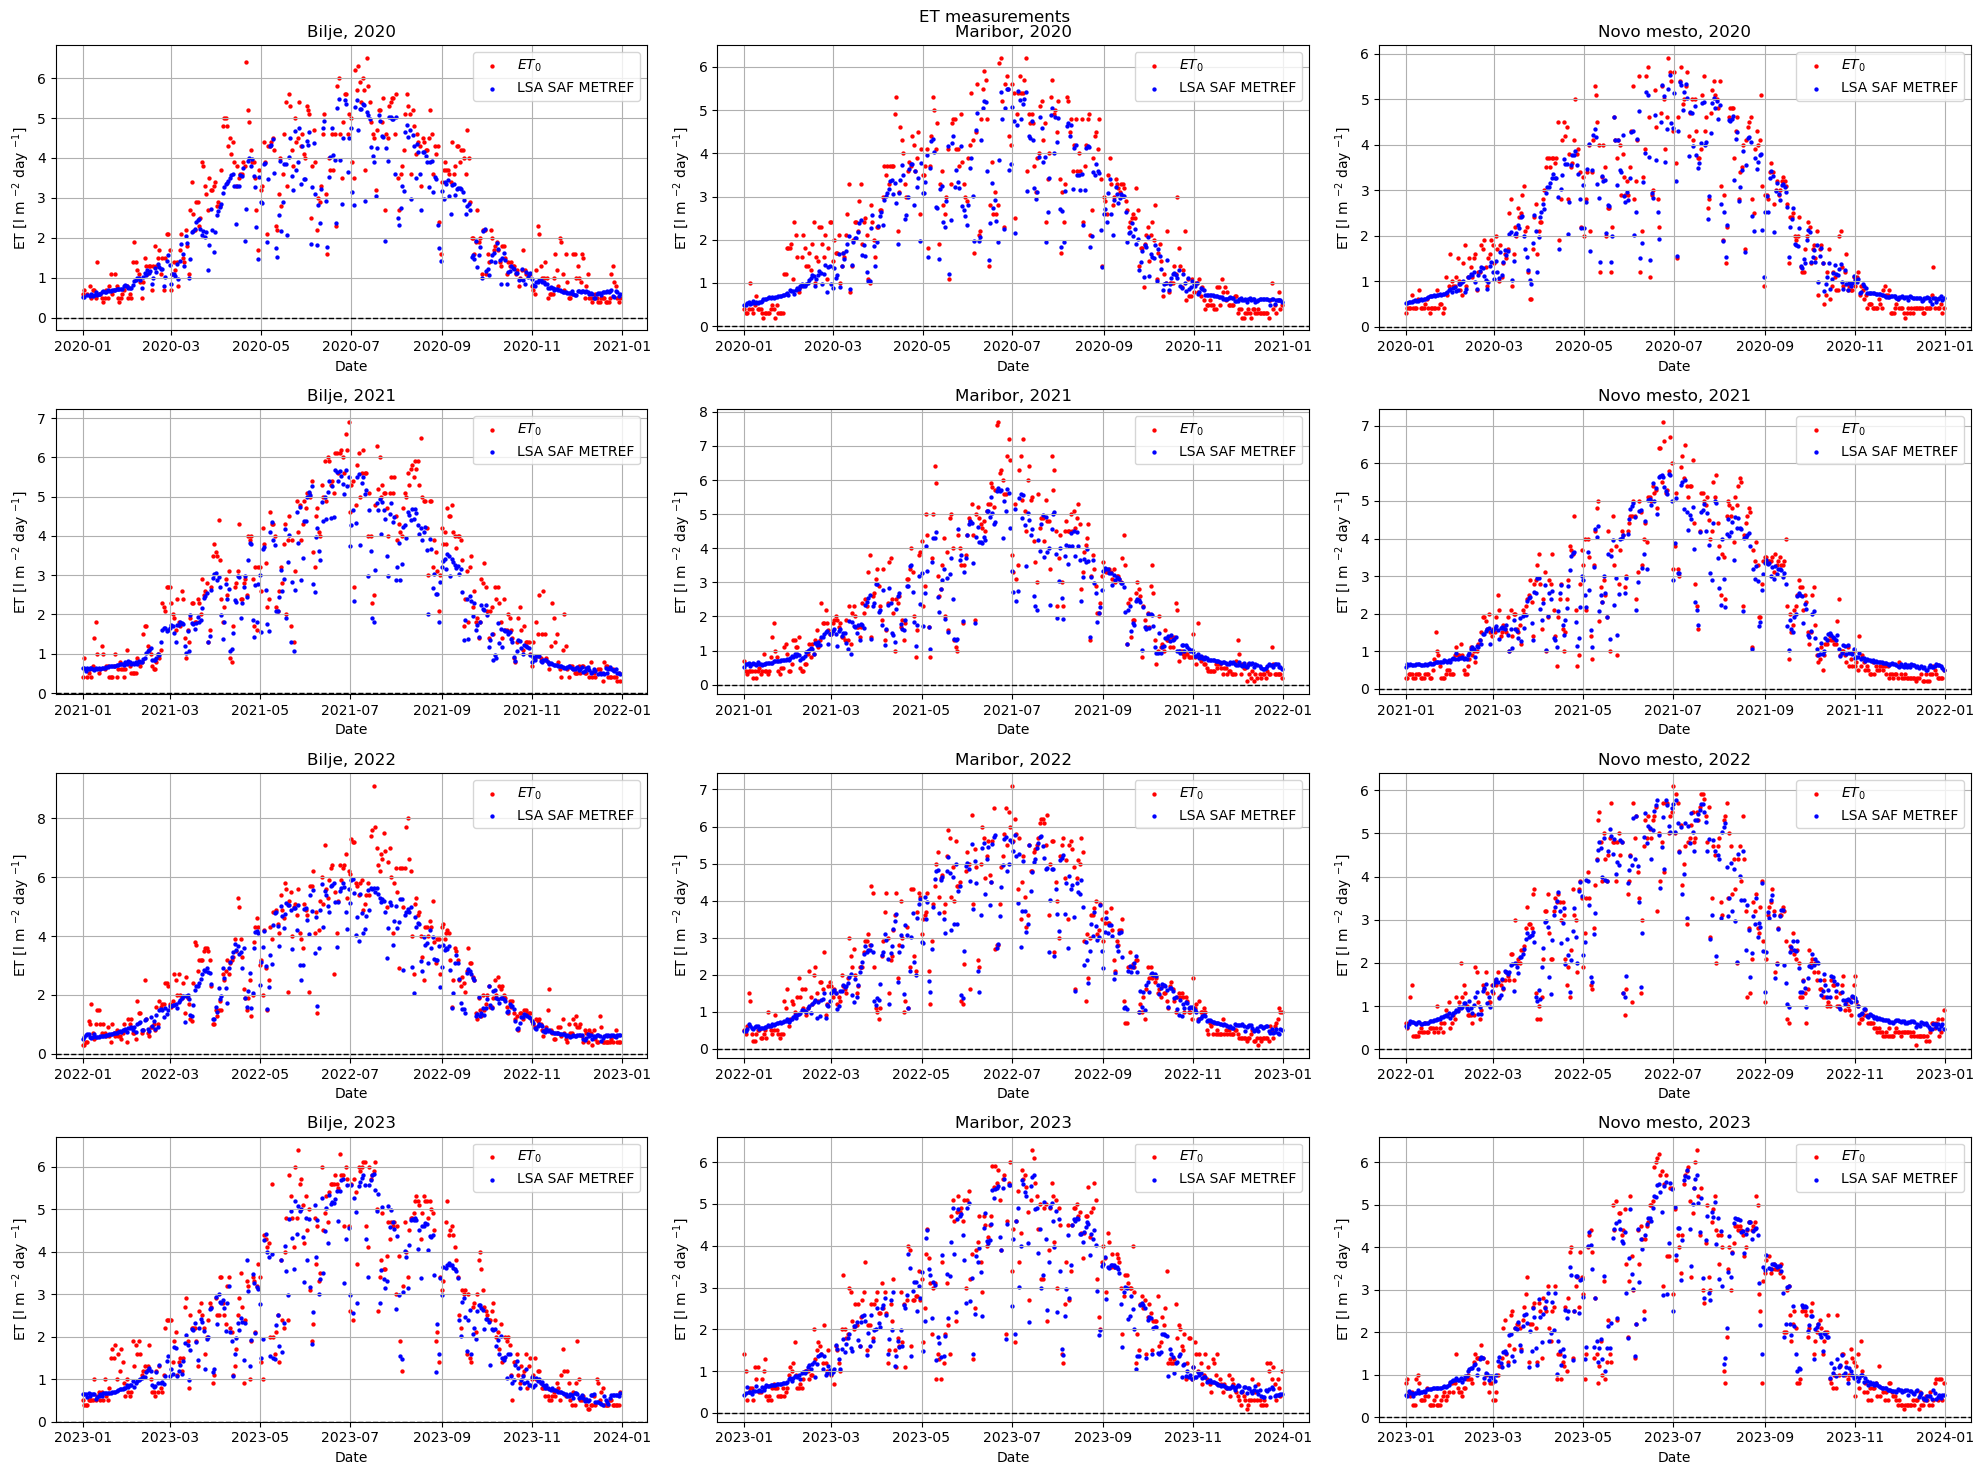

In [9]:
# Define figure and subplots
fig, axes = plt.subplots(ncols=len(locations), nrows=len(years), figsize=(20, 15), squeeze=False)

# Iterate over locations and years
for j, location in enumerate(locations):
    for i, year in enumerate(years):
        ax=axes[i, j]

        # Create a temporary dataframe and populate it with filtered values
        df_year_location = df[(df['date'].dt.year == year) & (df['name'] == location)]
        
        # Plot both sets of measurements
        ax.scatter(df_year_location['date'], df_year_location['ET0'], c="red", label=r'$ET_0$', s=4.5)
        ax.scatter(df_year_location['date'], df_year_location['METREF'], c="blue", label='LSA SAF METREF', s=4.5)

        # Drop the temporrary dataframe
        del df_year_location

        # Customize title, labels, legend, grid
        ax.set_title(f'{location}, {year}')
        ax.set_xlabel('Date')
        ax.set_ylabel(r'ET [l m $^{-2}$ day $^{-1}$]')
        ax.legend()
        ax.grid()
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1) 

# Set title
plt.suptitle("ET measurements")

# Set tight-layout() to avoid overlap of the subplots
plt.tight_layout()

# Save the plot, by default commented (uncomment to perform the line of code!)
#plt.savefig("ET_measurements.png")

From the figures we are able to observe a substantial seasonal and day-to-day variations of the ET0 values in the course of the general yearly cycle. 
Since ET has a yearly cycle as well as a daily weather dependency, significant day-to-day variations are to be expected.
By examining actual measurements we can observe that the LSA SAF METREF slightly underestimates ET0, but additional evidence would be needed to support that claim.


For the next plot, we show the difference between the LSA SAF METREF data and ET_PM values as time series.
Here we use a similar approach for plotting as in [4.1 - Creating subfigures](#Fourth-one).


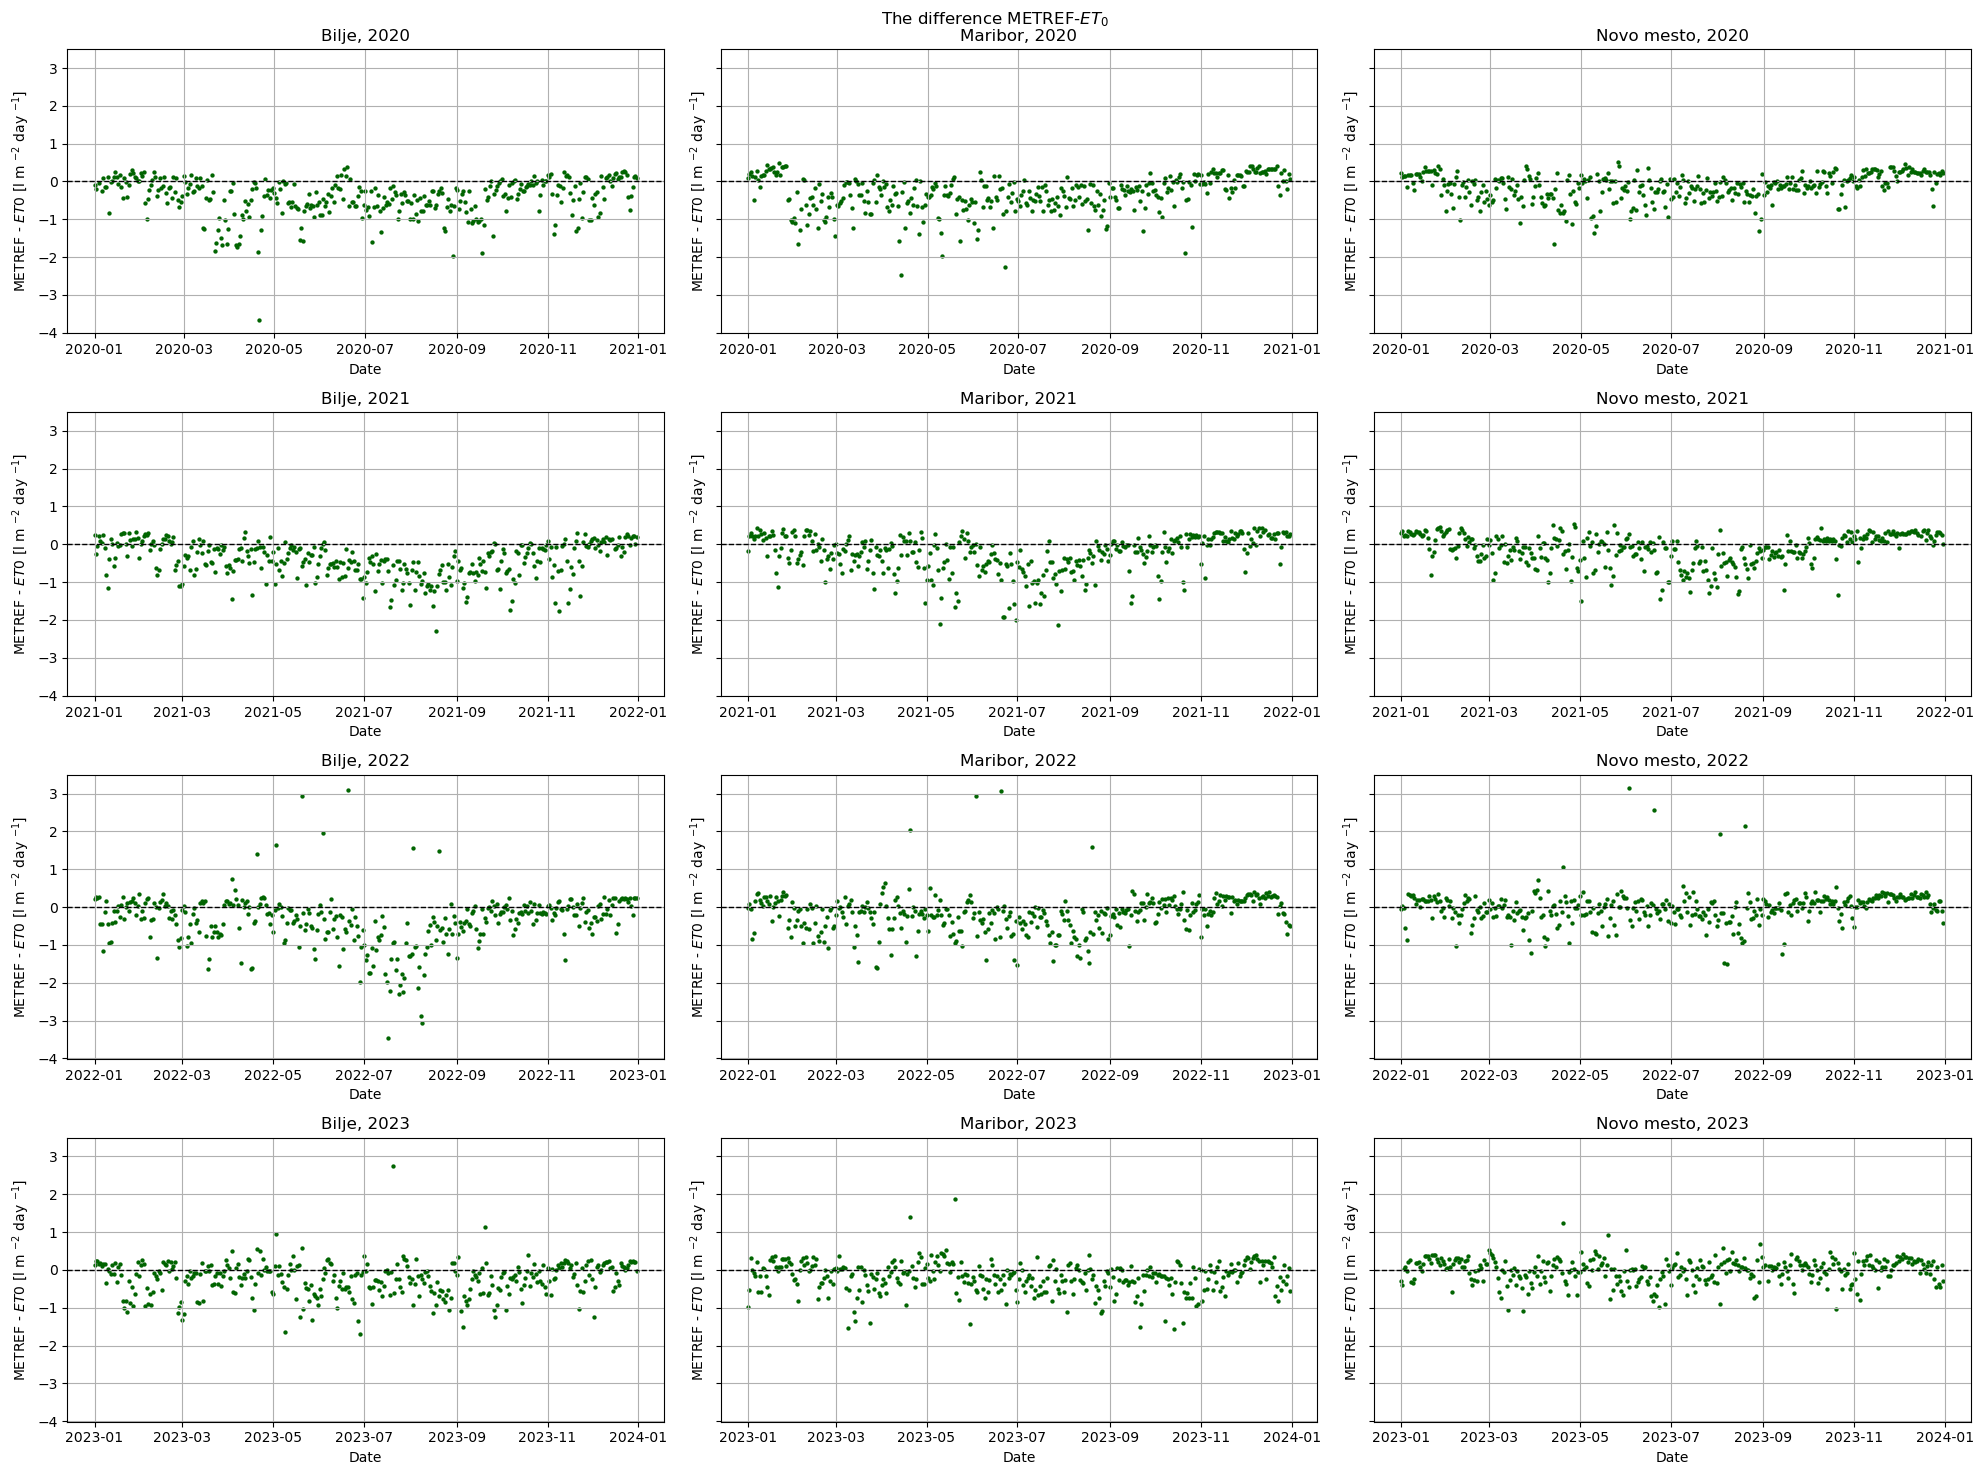

In [10]:
# Define figure and subplots
fig, axes = plt.subplots(ncols=len(locations), nrows=len(years), figsize=(20, 15), sharey=True)

# Iterate over locations and years
for j, location in enumerate(locations):
    for i, year in enumerate(years):
        ax=axes[i, j]

        # Create a temporary dataframe and populate it with filtered values
        df_year_location = df[(df['date'].dt.year == year) & (df['name'] == location)]

        # Plot the difference of the ET0 measurements calculated from two sources
        ax.scatter(df_year_location['date'], df_year_location['METREF-ET0'], c="darkgreen", label=r'METREF-ET_0', s=4.5)

        # Drop the temporary dataframe to free the memorry
        del df_year_location

        # Customize the title
        ax.set_title(f'{location}, {year}')
        ax.set_xlabel('Date')
        ax.set_ylabel(r'METREF - $ET0$ [l m $^{-2}$ day $^{-1}$]')
        ax.grid()

        # Plot a distinct line at x=0
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1) 

# Set suptitle
plt.suptitle(r"The difference METREF-$ET_0$")

# Set tight-layout() to avoid overlap of the subplots
plt.tight_layout()

# Save the plot, by default commented (uncomment to perform the line of code!)
#plt.savefig("ET_measurements.png")

It can be observed that the difference between METREF and ET_PM does not exhibit any clear seasonal effects.
Further analyzis showed that this was also the case for additional locations and years (not shown in this notebook). 
It seems that in some instances (particularly Bilje, 2022) such a seasonal systematic difference does exist. However, this is not detected over multiple cases nor does there exist a clear explanation for this particular systematic difference.

Another point worth noting are outliers, i.e., data points that differ significantly from other data. They are clearly visible on the subplots for Maribor, 2022 and Bilje, 2022. It is recommended to remove them before applying approaches such as time-averaging over the data.

### <a id='Fifth'></a>5. Comparing the Measurements

We plot the LSA SAF METREF and ET_PM data side by side in the form of a scatter plot. Such a plot allows detection of potential biases, as well as the identification of areas of un-proportionality.

We use the same code as in [4.1 - Plotting subfigures](#Fourth-one) except for minor enhancements. 
For easier analyzes, we also plot a blue line that indicates where LSA SAF METREF and ET_PM are equal (y=x).

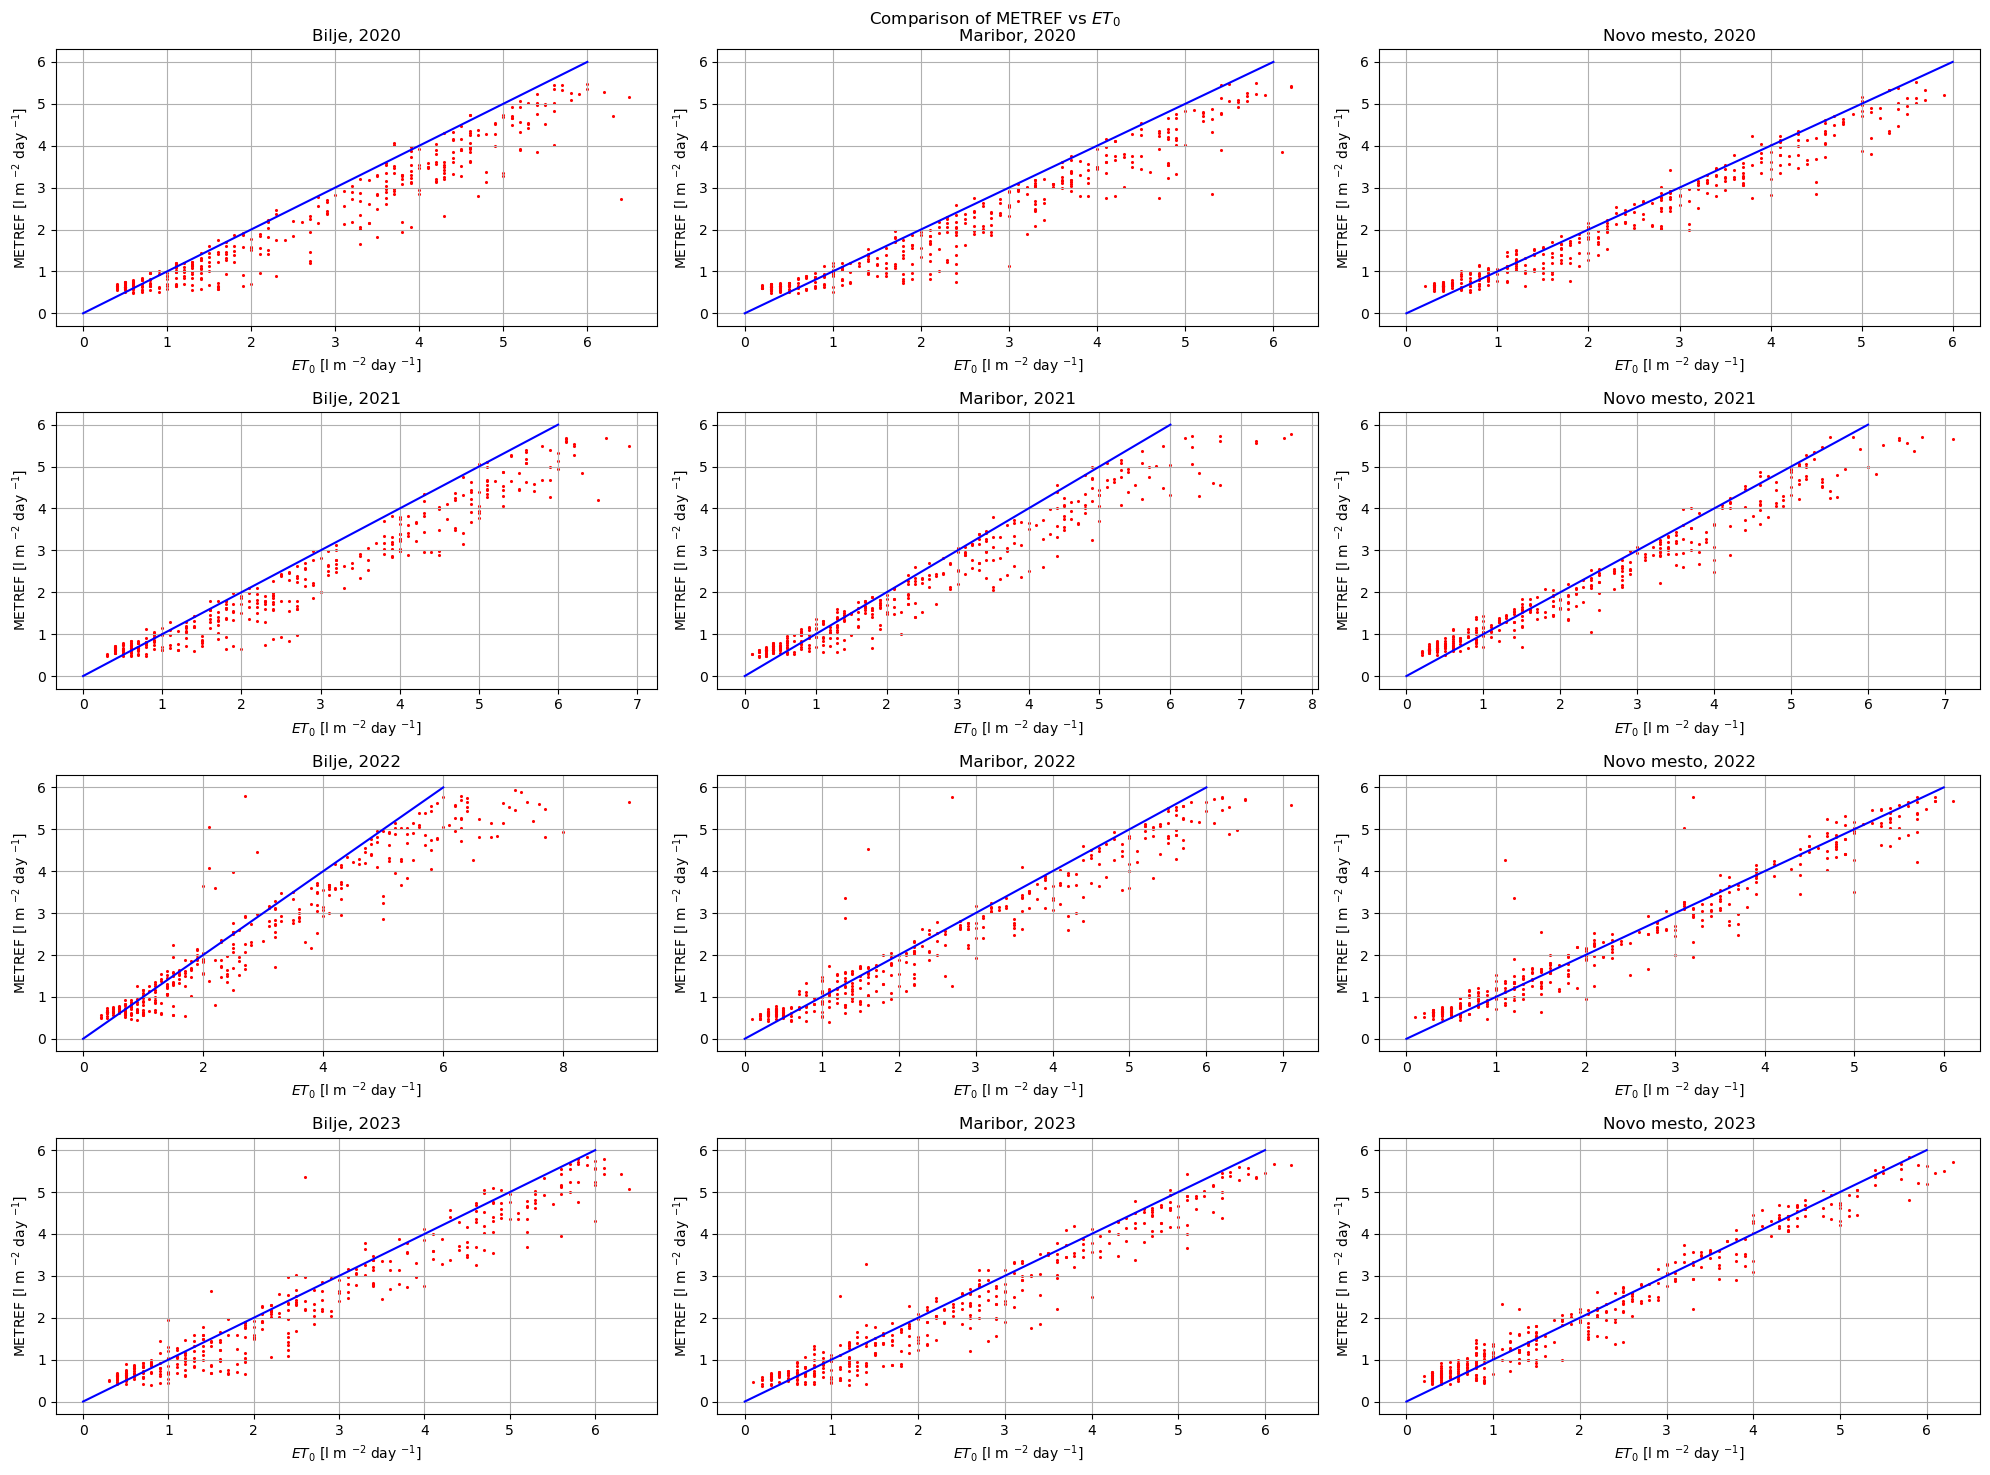

In [11]:
# Define figure and subplots
fig, axes = plt.subplots(ncols=len(locations), nrows=len(years), figsize=(20, 15))

# Iterate over locations and years
for j, location in enumerate(locations):
    for i, year in enumerate(years):
        ax=axes[i, j]

        # Define a temporary dataframe and populate it with filtered values
        df_year_location = df[(df['date'].dt.year == year) & (df['name'] == location)]

        
        # Plot the datapoints
        ax.scatter(df_year_location['ET0'], df_year_location['METREF'], c="red", s=1.5)

        # Drop the temporary dataframe, to free the memory
        del df_year_location

        # Plot the y=x line
        ax.plot([0,6],[0,6], c="blue")

        # Customize title, labels, grid
        ax.set_title(f'{location}, {year}')
        ax.set_xlabel(r'$ET_0$ [l m $^{-2}$ day $^{-1}$]')
        ax.set_ylabel(r'METREF [l m $^{-2}$ day $^{-1}$]')
        ax.grid()

# Set the suptitle
plt.suptitle(r"Comparison of METREF vs $ET_0$")

# Set tight-layout() to avoid overlap of the subplots
plt.tight_layout()

# Save the plot, by default commented (uncomment to perform the line of code!)
#plt.savefig("ET_diferences.png")

The blue line indicates the values in which both measurements are the same. It can be concluded, that the LSA SAF METREF estimations are generally smaller than ET_PM, which was already suggested before.

It can be also observed, that the distribution of the difference between both values seems to be of fairly constant width, but that will be more clearly demonstrated in the next chapter.

### <a id='Sixth'></a>6. Distribution of the METREF- ET_PM Difference

We prepare two kinds of plots here:

 * histogram of the METREF-ET_PM differences 
 * box plot with whiskers of the METREF-ET_PM differences 

We plot the histograms grouped by years and locations similarly to [4.1 - Plotting Subplots](#Fourth-one).
To calculate histograms we use the `pd.dataframe.plot()` and methods with the argument `ax=ax`, which allows us to attach the histogram as a subplot and apply additional customization using `pyplot`.

Such an approach would yield different sizes of bins on diferent subplots, which results in an unclear graph. 
Therefore, it is necessary to calculate the number of bins, by dividing the difference between the min and max values in the dataset and dividing by the desired bin size.

The `pd.dataframe.plot(kind='hist')` doesn't automatically show the mean value of the data, therefore this was calculated separately using `pd.dataframe.mean()`. 
The mean was then shown on the plot as a vertical dashed line, constructed using `ax.axvline()`.

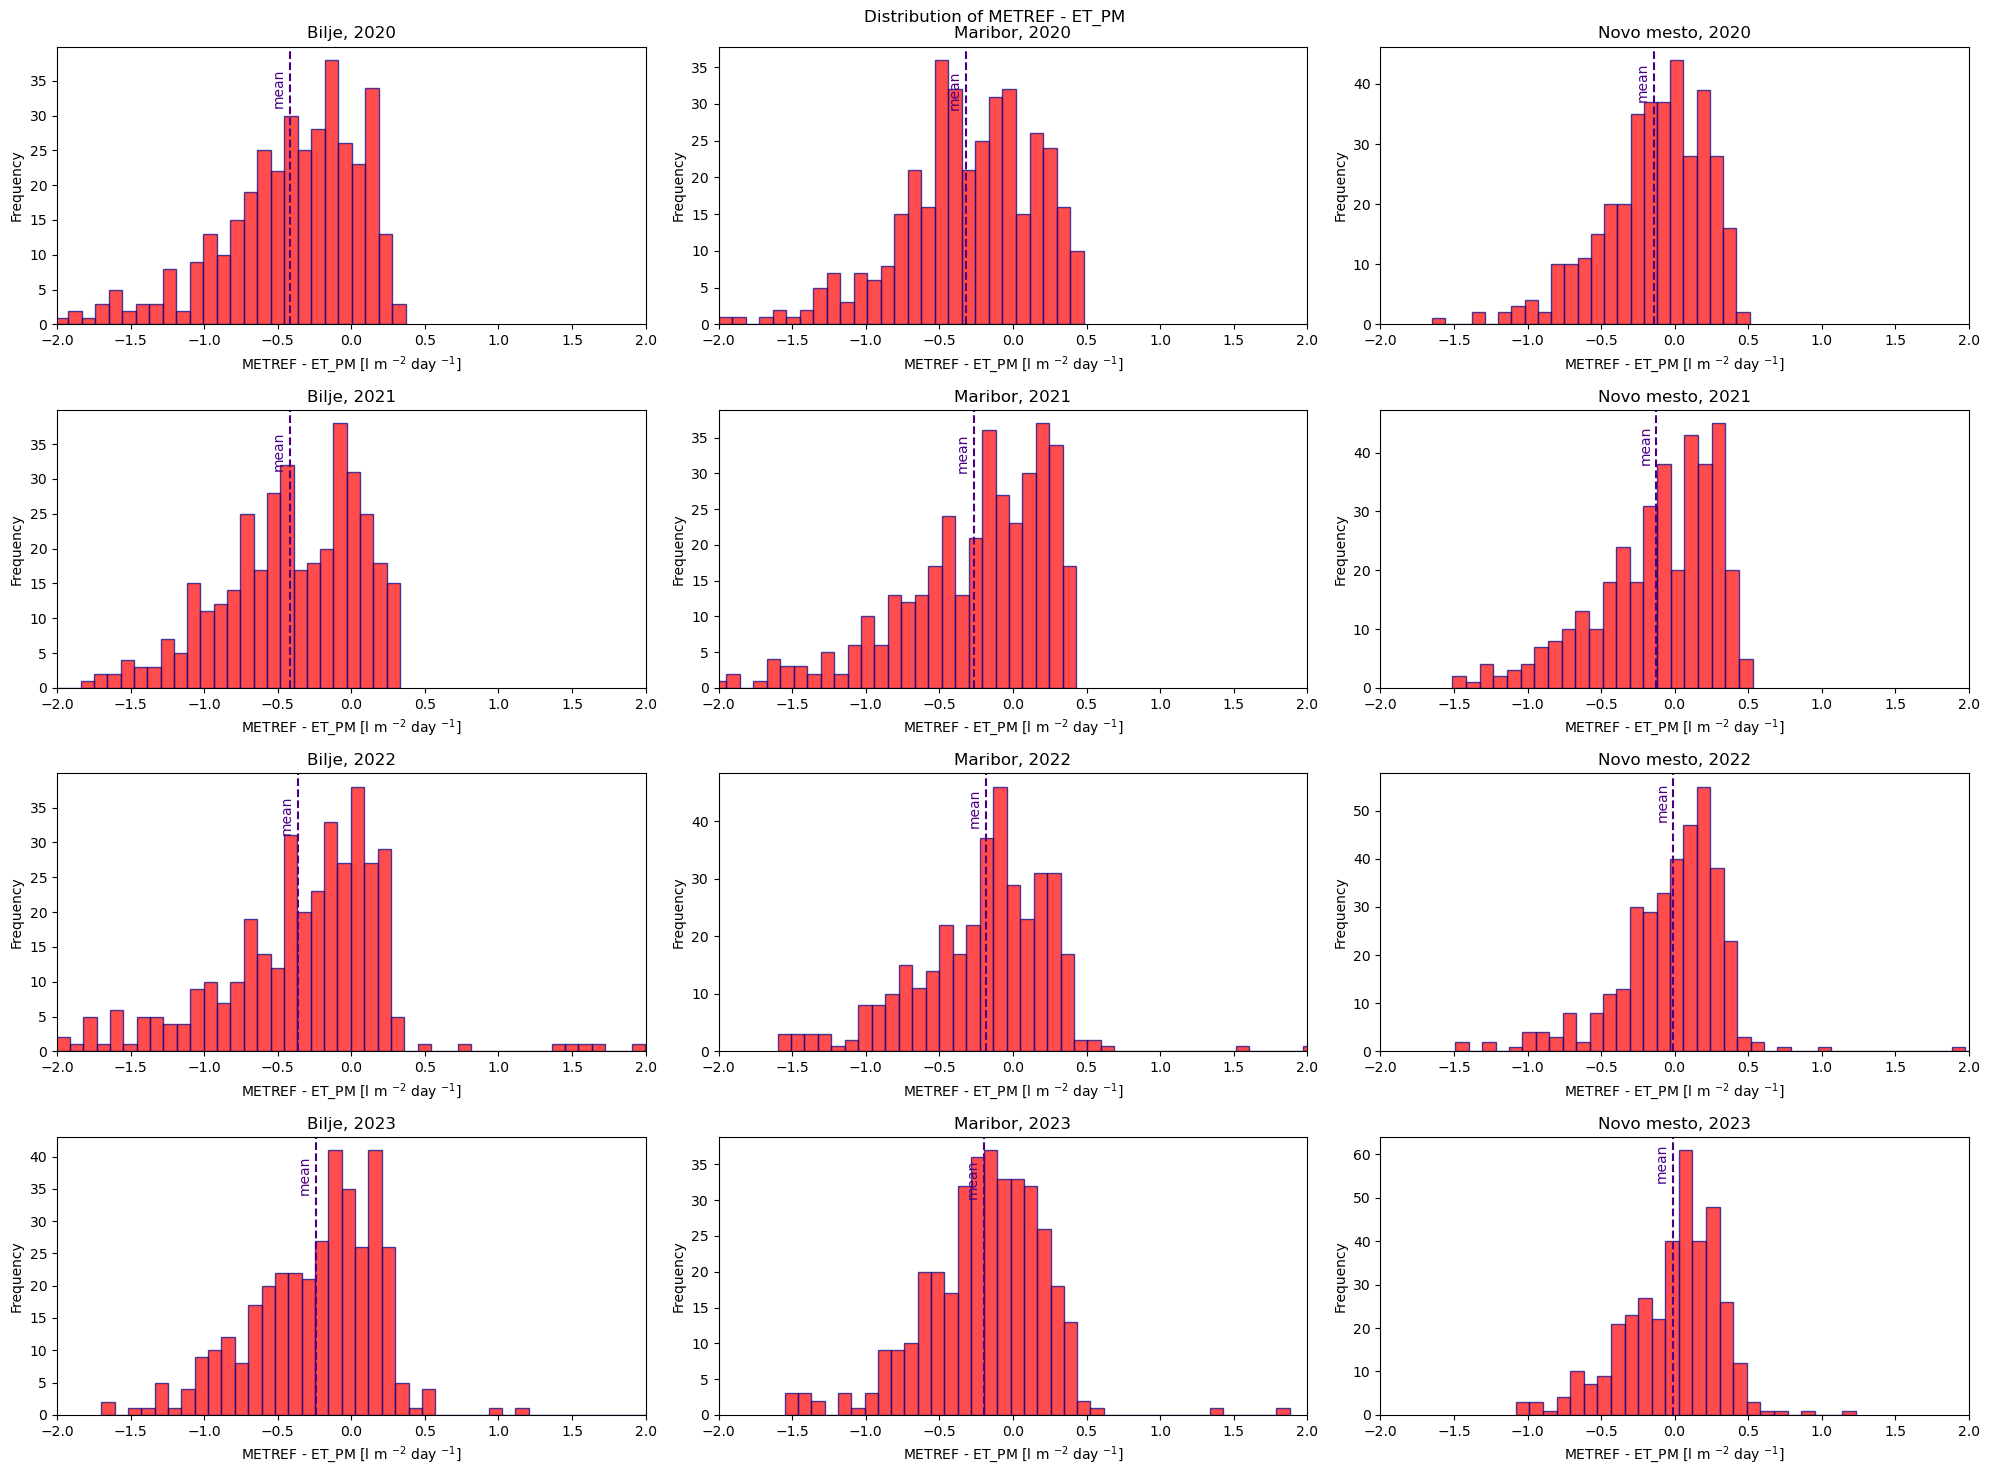

In [12]:
# Define figure and subplots
fig, axes = plt.subplots(ncols=len(locations), nrows=len(years), figsize=(20, 15))

# Iterate over locations and years 
for j, location in enumerate(locations):
    for i, year in enumerate(years):
        ax=axes[i, j]

        # Define a temporary dataframe and populate it with filtered values
        df_year_location = df[(df['date'].dt.year == year) & (df['name'] == location)]

        # Calculate number of bins
        bins=int((df_year_location['METREF-ET0'].max() - df_year_location['METREF-ET0'].min()) / 0.09)
        
        # Plot histogram
        df_year_location['METREF-ET0'].plot(kind='hist', bins=bins, ax=ax, color='red', edgecolor="darkblue", alpha=0.7)
        
        # Calculate the mean
        mean=df_year_location['METREF-ET0'].mean()

        # Plot the vertical line to mark the mean
        ax.axvline(x=mean, color='indigo', linestyle='--')
        
        # Drop the temporary dataframe
        del df_year_location

        # Customize the plot
        ax.text(mean-0.075, ax.get_ylim()[1]-6, r'mean', ha='center', va='center', color='indigo', rotation=90)
        ax.set_xlim(-2, 2)
        ax.set_title(f'{location}, {year}')
        ax.set_xlabel(r'METREF - ET_PM [l m $^{-2}$ day $^{-1}$]')
        ax.set_ylabel('Frequency')

# Set suptitle
plt.suptitle(r"Distribution of METREF - ET_PM")

# Set tight-layout() to avoid overlap of the subplots
plt.tight_layout()

# Save the plot, by default commented (uncomment to perform the line of code!)
#plt.savefig("METREF_ET0_hist.png")

The majority of histograms are centered near the mean value. The mean LSA SAF METREF and ET_PM difference is below zero for all figures, which indicates that METREF estimations are generally smaller than ET_PM ones.
The x-range on the plots is set manually, so that the position of the mean value can be directly comparable for all the subfigures. This means, that some outliers might be excluded from the plot.

In the next step, we can plot "boxes with whiskers". Such plot represents:
* Box: Interquartile range (IQR) between the 1st and the 3rd quartile,
* Whiskers: Show the range of the data. They extend to the furthest point in the 1.5 * IQR interval from the box,
* The line inside a box represents the median value.

The box plots are grouped into the subplots for each year.
They are produced using pandas `pyplot` wrapper otherwise similar to [4.1 - Plotting Subplots](#Fourth-one).
We can make a pyplot box plot using `pd.dataframe.boxplot()` where we need to specify a `column` in the `dataframe`, that we want to plot.
Additionally, we set the argument `by='name'` with which we specify, that we want to plot different boxes for each location with a different name.
We also need to include argument `patch_artist=True` to allow customization of the boxplot.

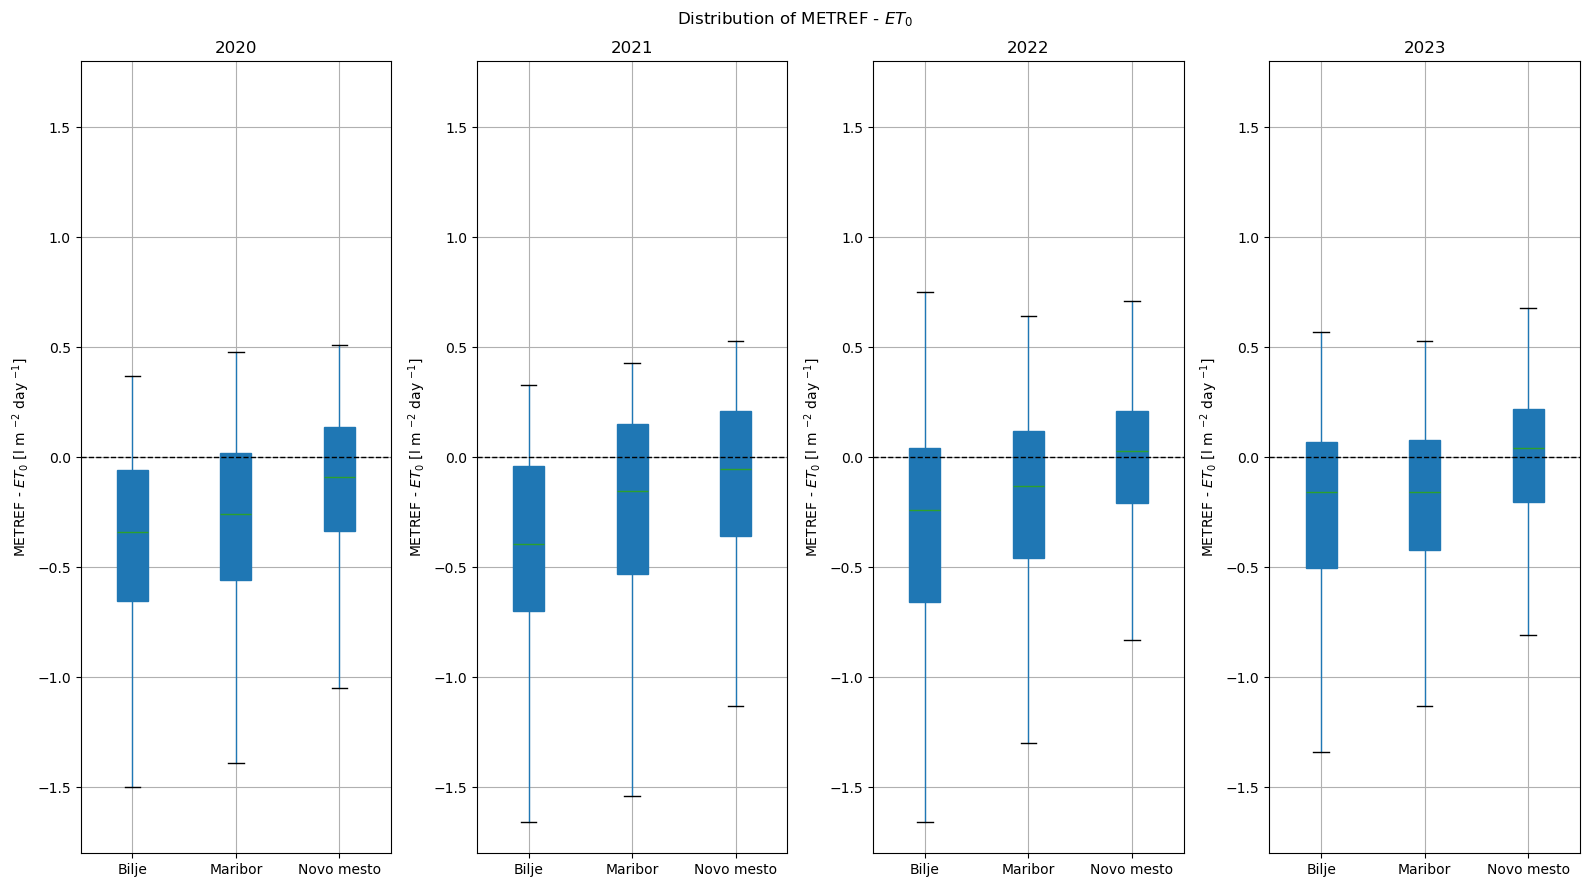

In [13]:
# Define figure and subplots
fig, axes = plt.subplots(ncols=len(years), nrows=1, figsize=(16, 9))

# Iterate over the years
for i, year in enumerate(years):
    ax=axes[i]

    # Define temporary dataframe and filter only the data for the desired year
    df_year = df[(df['date'].dt.year == year)]

    # Plot the boxplot
    df_year.boxplot(column='METREF-ET0', by='name', ax=ax, patch_artist=True, showfliers=False)

    # Drop the temporary dataframe
    del df_year

    # Customize the plot
    ax.set_title(f'{year}')
    ax.set_xlabel('')
    ax.set_ylabel(r'METREF - $ET_0$ [l m $^{-2}$ day $^{-1}$]')
    ax.set_ylim(-1.8,1.8)
    
    # Plot a distinct line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1) 


# Set the suptitle
plt.suptitle(r"Distribution of METREF - $ET_0$")

# Set tight-layout() to avoid overlap of the subplots
plt.tight_layout()

# Save the plot, by default commented (uncomment to perform the line of code!)
#plt.savefig("METREF_ET_boxplot.png")


### <a id='Seventh'></a>7. The Tukey Mean-Difference Plot

An additional possibility to graphically compare two different sets of measurements of the same physical quantity is the Tukey mean-difference plot, sometimes called (particularly in the fields of medicine and biostatistics) as [Bland-Altman plot](https://en.wikipedia.org/wiki/Bland%E2%80%93Altman_plot).
It is commonly used, when the truth (the actual value of measured quantity) is not exactly known.

In this case, we are plotting the difference between the two estimations $ET_1, ET_2$ as a function of the average value of these two estimations. 
$$ ET(x,y) = \big( \frac{ET_1 + ET_2}{2} , ET_1 - ET_2 \big) $$ 
It represents how the difference between the two methods depends on the measured value.

The lines for the mean difference and a range in which 95% of differences lay are usually also represented. Assuming that the differences comply with the Gaussian distribution with the mean value $\mu$ and standard deviation $\sigma$, then approximately 68% of differences lie within the $\mu \pm  \sigma$ interval and  95,4% within $\mu \pm 2 \sigma$ interval and the interval that includes exactly 95% of the differences corresponds to $\mu \pm 1.96 \sigma$.

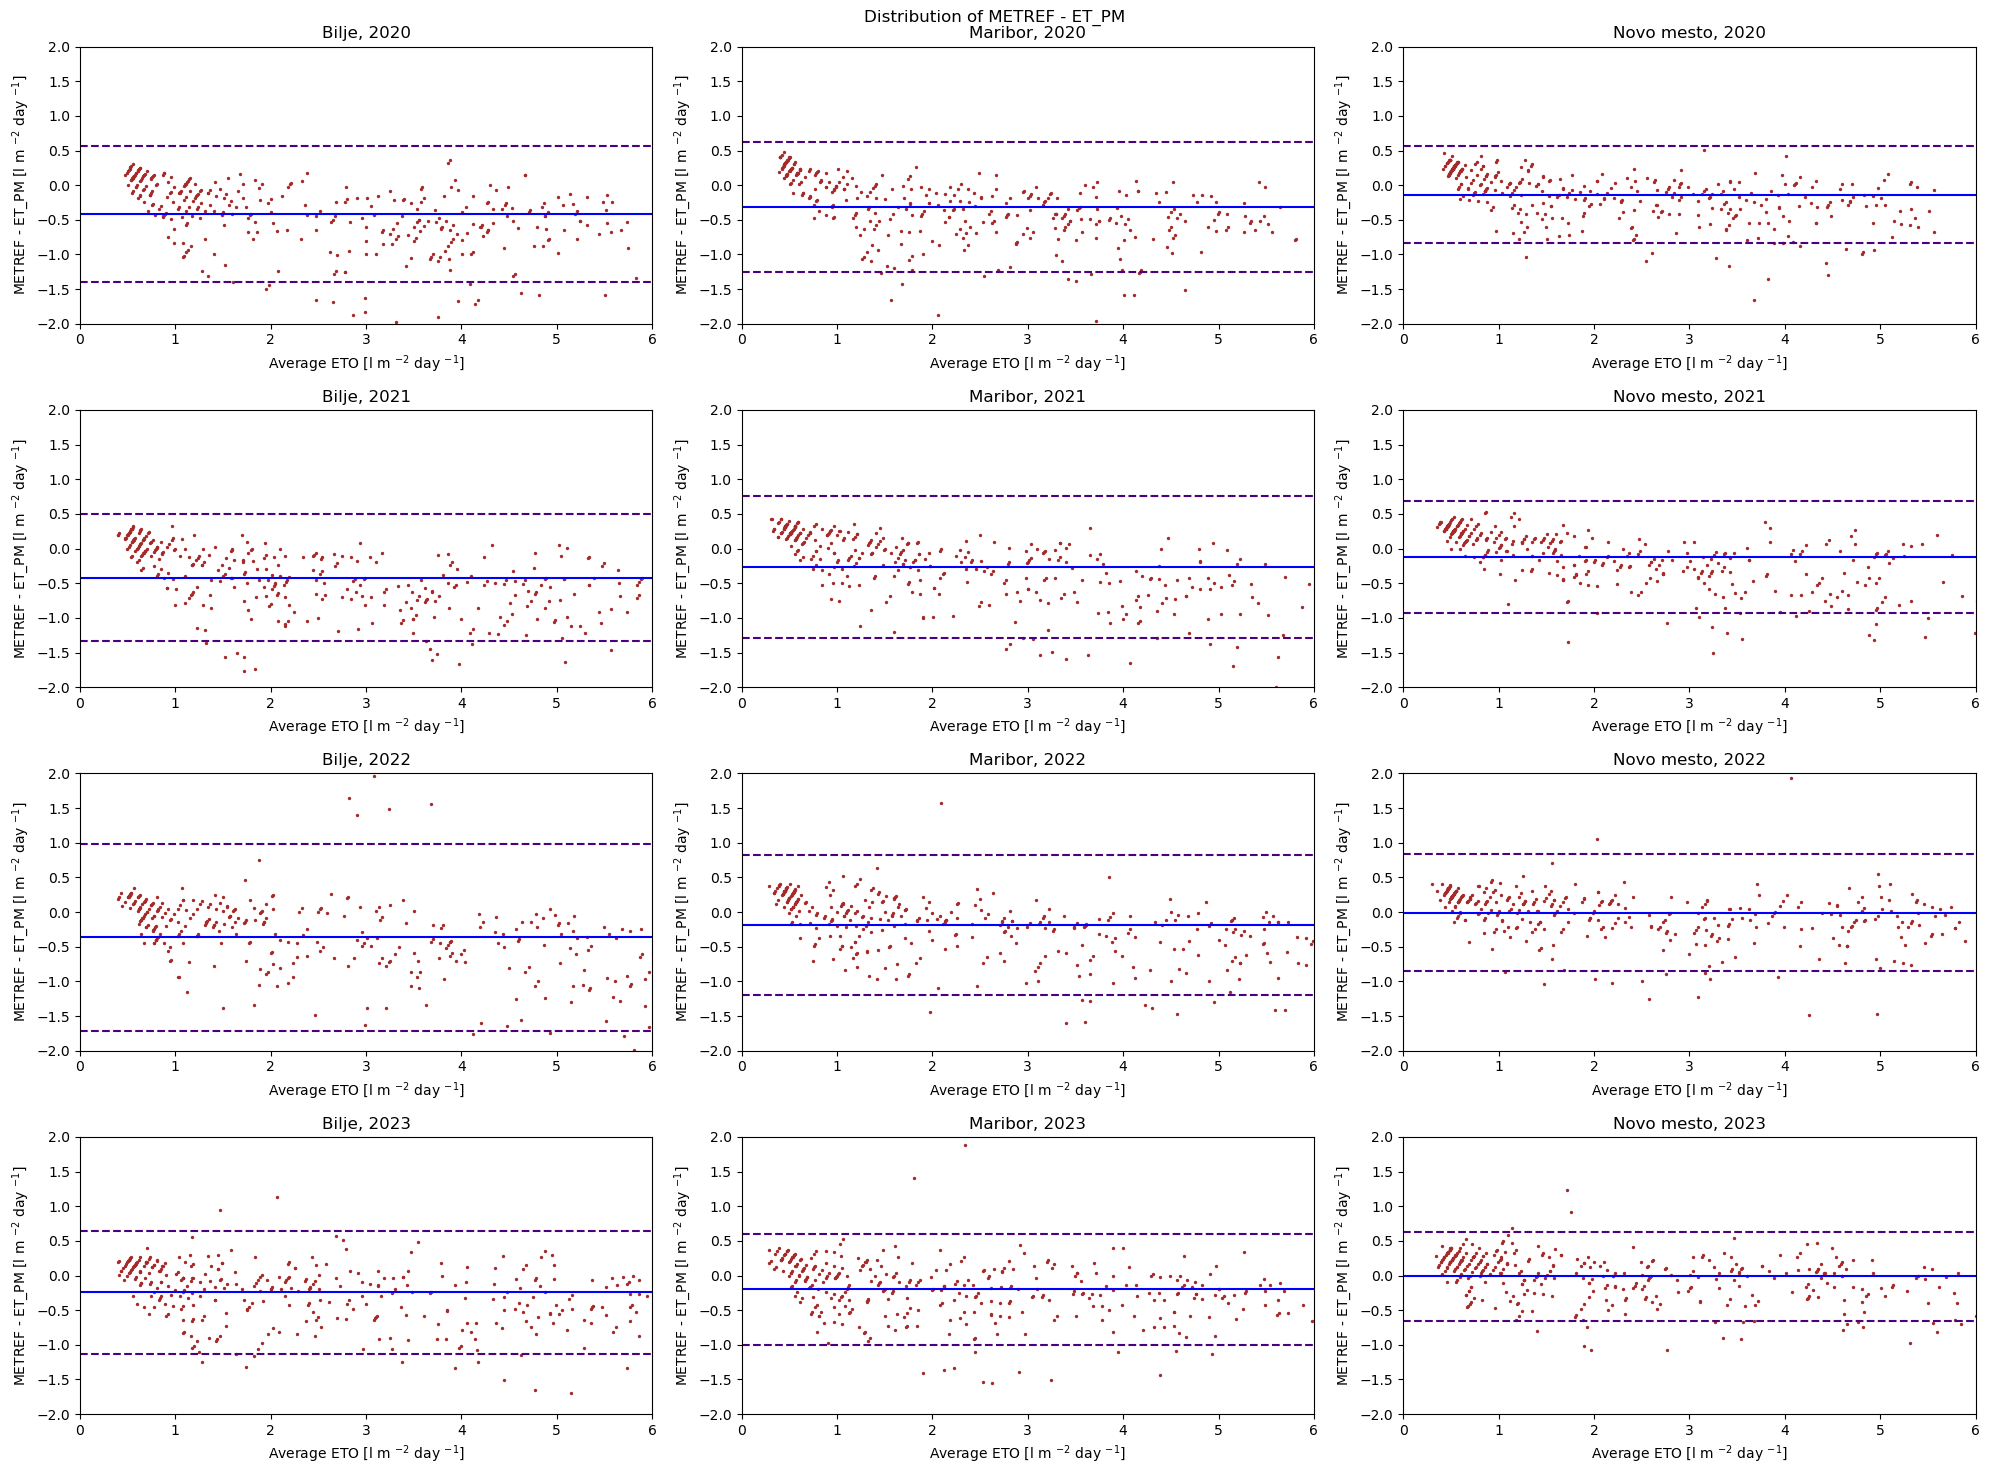

In [14]:
# Define figure and subplots
fig, axes = plt.subplots(ncols=len(locations), nrows=len(years), figsize=(20, 15))

# Iterate ove locations and years
for j, location in enumerate(locations):
    for i, year in enumerate(years):
        ax = axes[i, j]

        # Define temporary dataframe and filter only the data for the desired year and location
        df_year_location = df[(df["date"].dt.year == year) & (df["name"] == location)]

        # Plot the datapoints
        ax.scatter(
            0.5 * ( df_year_location["METREF"] + df_year_location["ET0"] ),
            df_year_location["METREF-ET0"],
            c="brown",
            s=2,
        )

        # Calculate the mean value and st_dev
        mean = df_year_location["METREF-ET0"].mean()
        st_dev = df_year_location["METREF-ET0"].std()

        # Drop the temporrary dataframe, to free the memorry
        del df_year_location

        # Add horizontal lines for mean and borders of the 95% interval
        ax.axhline(y=mean, color="blue", linestyle="solid")
        ax.axhline(y=mean + 1.96 * st_dev, color="indigo", linestyle="--")
        ax.axhline(y=mean - 1.96 * st_dev, color="indigo", linestyle="--")

        # Customize the plot
        ax.set_xlim(0, 6)
        ax.set_ylim(-2, 2)
        ax.set_title(f"{location}, {year}")
        ax.set_xlabel(r"Average ETO [l m $^{-2}$ day $^{-1}$]")
        ax.set_ylabel(r"METREF - ET_PM [l m $^{-2}$ day $^{-1}$]")

# Set the suptitle
plt.suptitle(r"Distribution of METREF - ET_PM")

# Set tight-layout() to avoid overlap of the subplots
plt.tight_layout()

# Save the plot, by default commented (uncomment to perform the line of code!)
# plt.savefig("METREF_ET_Tukey_Mean_Difference.png")

The resulting Tukey mean-difference plots demonstrate, that, on average LSA SAF METREF values are smaller than than ET_PM estimations by approximately 1.0 L/(m² day). At lower values of ET0, LSA SAF METREF is actually greater than ET_PM.

For many applications, the issues with small ET0 values are not important, particularly when we want to use ET for agriculture-related applications. As was demonstrated before, ET0 values in Slovenia are generally below 1.0 L/(m² day) only during the winter when there is no active vegetation, and consequently, ET0 is of less value for agricultural applications.


### <a id='Eighth'></a>8. Uncertainty Assessment

To conclude our analysis, we also assess the uncertainty interval (95% confidence interval or $ \mu \pm 1.96 \sigma$) on which we can use LSA SAF METREF and ET_PM at any analyzed location interchangeably. In other words, we try to understand with what confidence we can use LSA SAF METREF instead of ET_PM, therefore, we define ET_PM as the truth.

We also observed, that there are small but detectable differences among magnitudes of underestimation at various locations. We can see from the [histogram plot](#Sixth), that the mean difference between ET_PM and METREF is the largest in Bilje and the smallest in Novo mesto.  Unsurprisingly, we are thus able to conclude, that different locations could have different uncertainties. We print the standard deviation and the mean difference between LSA SAF METREF and ET_PM, as well as the 95% confidence interval for all the differences sorted by location and year.

In [15]:
# Define the empty dataframe
df_results = pd.DataFrame(columns=['name', 'mean', 'stdev', 'confidence interval (1.96*stdev)'])

# Iterate over all the locations
for location in locations:

        # Define a temporary dataset
        df_location = df[(df['name'] == location)]

        # Calculate mean difference
        mean=df_location['METREF-ET0'].mean()

        # Calculate the standard deviation
        st_dev=df_location['METREF-ET0'].std()
        
        # Construct a row dataset
        row=pd.DataFrame({'name' : [location], 'mean': [mean], 'stdev' : [st_dev],'confidence interval (1.96*stdev)' : [1.96*st_dev]})
        
        # Exclude empty or NaN entries before concatenating
        if not df_results.empty:
            df_results = pd.concat([df_results, row], ignore_index=True)
        else:
            df_results = row

# Print the results rounded to 1 decimal
print(df_results.round(decimals=1))

         name  mean  stdev  confidence interval (1.96*stdev)
0       Bilje  -0.4    0.5                               1.1
1     Maribor  -0.2    0.5                               0.9
2  Novo mesto  -0.1    0.4                               0.8


We can see that the mean difference is in all analyzed cases negative. Thus, the LSA SAF METREF product yields smaller values than the ET_PM at all locations.
At the three locations, the variance (third column) is larger than the mean difference (second column), which means that the variance is greater than the bias. Based on these statistics, we can assume that uncertainty is to larger degree dependant on the variance (rather on the bias).

Looking at our data, we can conclude that the  LSA SAF METREF and ET_PM estimations differ approximately at ±1 L/(m² day) in Bilje, Maribor and Novo mesto in years 2020-2023.


#### Conclusion

We highlighted several methodologies for comparing ET0 from the LSA SAF METREF data with an in-situ estimation of ET0 by the Penmann-Monteith method.
From the visualized data we can conclude that in this sample the LSA SAF METREF data are generally slightly smaller tha ET_PM estimations.
In the dataset, we did not find any seasonal or other temporal biases.
Majority of the differences are located inside the $\pm 1$ l m $^{-2}$ day $^{-1}$ interval.

#### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 27.3.2024.
* Richard G. A. et all. Crop evapotranspiration - Guidelines for computing crop water requirements. [https://www.fao.org/3/X0490E/x0490e00.htm](https://www.fao.org/3/X0490E/x0490e00.htm). Accesed: 27.3.2024.